In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import cv2
import random
from imgaug import augmenters as iaa

from keras.layers import Conv1D, MaxPool1D, Dropout, Flatten
import keras
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.layers import Convolution2D as C2D, MaxPooling2D as MP2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data= pd.read_csv('data/self_driving_car_dataset_make/driving_log.csv',names = columns)

In [3]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,IMG\center_2022_04_10_12_24_41_840.jpg,IMG\left_2022_04_10_12_24_41_840.jpg,IMG\right_2022_04_10_12_24_41_840.jpg,0.0,0.0,0,0.000013
1,IMG\center_2022_04_10_12_24_41_908.jpg,IMG\left_2022_04_10_12_24_41_908.jpg,IMG\right_2022_04_10_12_24_41_908.jpg,0.0,0.0,0,0.000010
2,IMG\center_2022_04_10_12_24_41_976.jpg,IMG\left_2022_04_10_12_24_41_976.jpg,IMG\right_2022_04_10_12_24_41_976.jpg,0.0,0.0,0,0.000008
3,IMG\center_2022_04_10_12_24_42_044.jpg,IMG\left_2022_04_10_12_24_42_044.jpg,IMG\right_2022_04_10_12_24_42_044.jpg,0.0,0.0,0,0.000021
4,IMG\center_2022_04_10_12_24_42_116.jpg,IMG\left_2022_04_10_12_24_42_116.jpg,IMG\right_2022_04_10_12_24_42_116.jpg,0.0,0.0,0,0.000014


In [4]:
data.shape

(3930, 7)

In [5]:
data.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'], dtype='object')

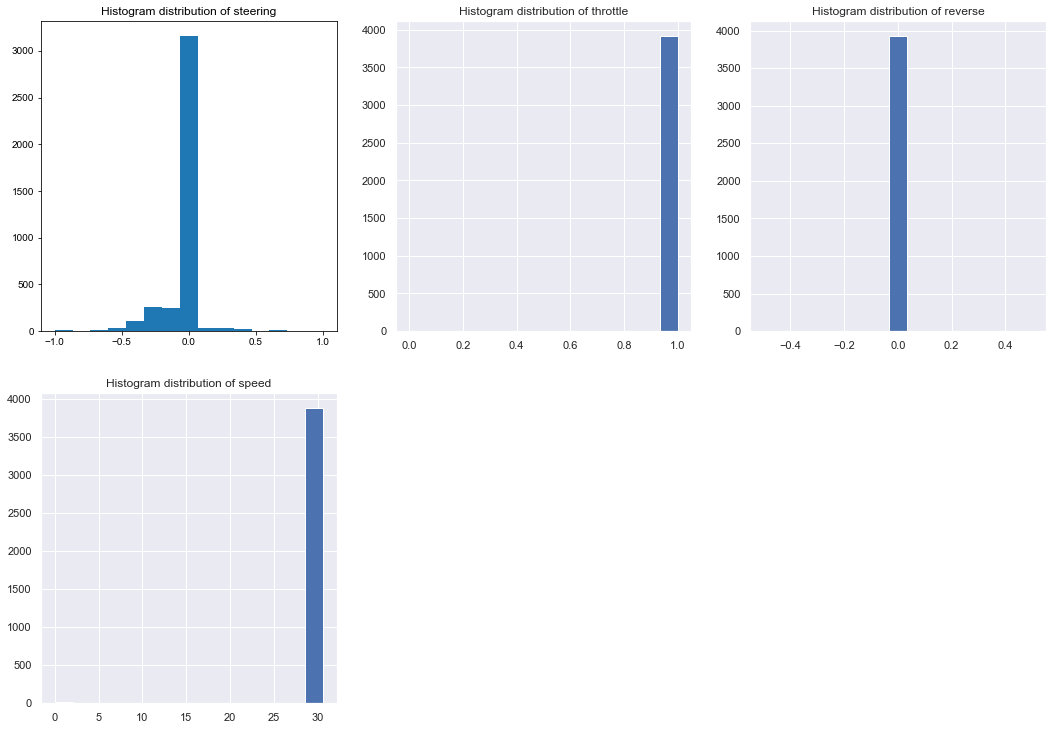

In [6]:

num_cols= ['steering', 'throttle', 'reverse', 'speed']

plt.figure(figsize=(18,18))
for i,j in zip(range(1,18),num_cols):
    plt.subplot(6, 3, i)
    plt.subplots_adjust(right=0.9,top=1.8)
    plt.hist(data[j], bins = 15)
    sns.set_theme()
    plt.title('Histogram distribution of {}'.format(j))



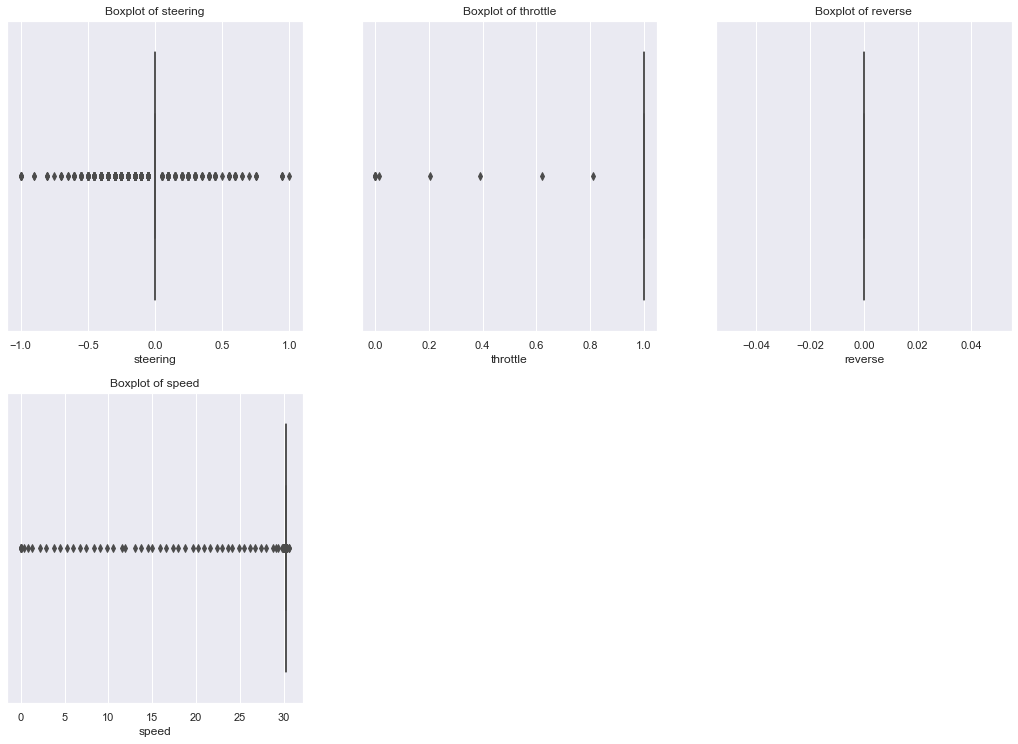

In [7]:
plt.figure(figsize=(18,18))
for i,j in zip(range(1, 18),num_cols):
    plt.subplot(6, 3, i)
    plt.subplots_adjust(right=0.9,top=1.8)
    sns.boxplot(data=data, x=j)
    sns.set_theme()
    plt.title('Boxplot of {}'.format(j))

# VGG16 with random forest

In [8]:
from keras.preprocessing.image import ImageDataGenerator as IDG
datagen = IDG(validation_split=0.2)

In [9]:
train_generator=datagen.flow_from_dataframe(
  dataframe=data,
  directory="data/self_driving_car_dataset_make/",
  x_col="center",
  y_col="steering",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(160, 320),
)

valid_generator=datagen.flow_from_dataframe(
  dataframe=data,
  directory="data/self_driving_car_dataset_make/",
  x_col="center",
  y_col="steering",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(160, 320),
)



Found 3144 validated image filenames.
Found 786 validated image filenames.


In [10]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg19 = VGG19(
    weights='imagenet',
    input_shape=(66,200,3),
    include_top=False,
    pooling='max'
)

vgg19_algo = Sequential()
vgg19_algo.add(vgg19)
vgg19_algo.add(Dense(units = 120, activation='relu'))
vgg19_algo.add(Dense(units = 120, activation = 'relu'))
vgg19_algo.add(Dense(units = 120, activation='relu'))
vgg19_algo.add(Dense(units = 120, activation = 'relu'))
vgg19_algo.add(Dense(units = 120, activation='relu'))
vgg19_algo.add(Dense(units = 120, activation = 'relu'))
vgg19_algo.add(Dense(units = 120, activation='relu'))
vgg19_algo.add(Dense(units = 120, activation = 'relu'))
vgg19_algo.add(Dense(units = 1))
vgg19_algo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 120)               61560     
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dense_3 (Dense)             (None, 120)               14520     
                                                                 
 dense_4 (Dense)             (None, 120)               14520     
                                                                 
 dense_5 (Dense)             (None, 120)               1

In [11]:
fe=vgg19_algo.predict(train_generator)

features = fe.reshape(fe.shape[0], -1)

ml_features = features

99/99 [==============================] - 304s 3s/step


In [12]:
from sklearn.ensemble import RandomForestRegressor as RFE
clf = RFE(n_estimators = 42, random_state = 42)
clf.fit(ml_features,train_generator.labels)

RandomForestRegressor(n_estimators=42, random_state=42)

In [14]:
feature_te = vgg19_algo.predict(valid_generator)
feature_te = feature_te.reshape(feature_te.shape[0], -1)

25/25 [==============================] - 72s 3s/step


In [15]:
pr=clf.predict(feature_te)

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print('Mean Squared Error of the VGG19 with random forest regressor is :', mse(valid_generator.labels, pr))
print('Mean Absolute Error of the VGG19 with random forest regressor is :', mae(valid_generator.labels, pr))


Mean Squared Error of the VGG19 with random forest regressor is : 0.025474730956023522
Mean Absolute Error of the VGG19 with random forest regressor is : 0.08511602194656487


# Vgg19 with linear regression

In [16]:
from sklearn.linear_model import LinearRegression as LR

reg= LR()
reg.fit(ml_features,train_generator.labels)

LinearRegression()

In [17]:
pr=reg.predict(feature_te)

print('Mean Squared Error of the VGG19 with linear regression is :', mse(valid_generator.labels, pr))
print('Mean Absolute Error of the VGG19 with linear regrssion is :', mae(valid_generator.labels, pr))


Mean Squared Error of the VGG19 with linear regression is : 0.015579651745213204
Mean Absolute Error of the VGG19 with linear regrssion is : 0.06505835844216971
